# Texture Normal Mapper

## SCC0251.2020.1 - Image Processing

### Prof. Dr. Moacir Ponti

### Renata Vinhaga dos Anjos (10295263) and Vitor Gratiere Torres (10284952)

#### Description

Our idea is to create a normal mapper for textures, calculating light bumps and deviations to simplify 3d meshes improving render speed while maintaining render quality.

Provinding an 2d image, we want to calculate it's heightmap from its pixel's light values.

Out of it, we will scan in x and y axes with it's gradient from Sobel-Feldman operator, creating thus a normal map.

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [83]:
# r = imageio.imread(str(input()).rstrip())
r = imageio.imread(str("/home/ava/documents/classes/nm/NormalMapping/images/brick_rough_256x256.jpg").rstrip()).astype(np.uint8)

In [66]:
# Invert
def inv(img):
    return 255 - img

# Normalize
def scale(image, c=0, d=255):
    a = np.min(image)
    b = np.max(image)
    return ((image-a)*((d-c)/(b-a))+c).astype(np.uint8)

#### Sobel-Feldman operator

Sobel-Feldman operator is an edge detector, it uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. If we define $A$ as the source image, and $Gx$ and $Gy$ are two images which at each point contain the vertical and horizontal derivative approximations respectively, the computations are as follows:

$$G_x = \begin{bmatrix}-3 & 0 & 3\\-10 & 0 & 10\\-3 & 0 & 3\end{bmatrix}$$

$$G_y = \begin{bmatrix}-3 & -10 & -3\\0 & 0 & 0\\3 & 10 & 3\end{bmatrix}$$

Then we'll crop $A$ matrix to fit kernel's shape, iterate and convolute it.

> It is also possible to use $G_x$ and $G_y$ with 1s instead of 3s, and 2s instead of 10s, it's just a matter of factors and scales. 3s and 10s got us our best outcome so far.

The x-coordinate is defined here as increasing in the "right"-direction, and the y-coordinate is defined as increasing in the "down"-direction. At each point in the image, the resulting gradient approximations can be combined to give the gradient magnitude, using $G = \sqrt{G_x^2 + G_y^2}$. Using this information, we can also calculate the gradient's direction as $\theta = atan\left(\frac{G_y}{G_x}\right)$, this angle $\theta$ tells us the light's angle, while the $G$ vector is the light's vector itself.

The components $G_x$ and $G_y$ devided by its' square root gives us the unitary components.

The $x$ component will be depicted as our reds, while the $y$ as our greens. Our blue component comes from the height map itself. All of them are scaled to $0-255$. The last operation is to cut through the threshold.

In [56]:
def sobel(img, threshold=.05):
    #     Gx = np.array([[-1, 0, 1],
    #                    [-2, 0, 2],
    #                    [-1, 0, 1]])
    #     Gy = np.array([[-1, -2, -1],
    #                    [0, 0, 0],
    #                    [1, 2, 1]])
    Gx = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [-3, 0, 3]])
    Gy = np.array([[-3, -10, -3],
                   [0, 0, 0],
                   [3, 10, 3]])
    
    shp = np.array(img.shape)[0:2]
    img = np.pad(img, 1, 'edge')

    if np.array(img.shape)[0] == 3:
        # image isn't greyscale, convert
        img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])

    sob = np.zeros(shp)
    res = np.zeros(np.array([shp[0], shp[1], 3]))

    for i in range(0, shp[0]):
        for j in range(0, shp[1]):
            S1 = np.sum(np.multiply(Gx, img[i:i+3, j:j+3]))
            S2 = np.sum(np.multiply(Gy, img[i:i+3, j:j+3]))

            sob[i, j] = np.sqrt(S1**2 + S2**2)
            if sob[i, j] != 0:
                res[i, j, 0] = S1/sob[i, j] * 255
                res[i, j, 1] = S2/sob[i, j] * 255
            else:
                res[i, j, 0] = 0
                res[i, j, 1] = 0
            res[i, j, 2] = sob[i, j]

    sob = scale(sob)
    res = scale(res)
    res[:,:,2] = inv(res[:,:,2])
    
    threshold = int(round(threshold * 255))
    sob[sob < threshold] = 0
    res[res < threshold] = 0
    return sob, res

In [89]:
def sobel2(img, strength):
    shp = np.array(img.shape)[0:2]
    sob = np.zeros(shp)
    if np.array(img.shape).shape[0] == 3:
        sob[:,:] = img[:,:,0] + img[:,:,1] + img[:,:,2]
        sob = sob/3
    else:
        sob[:,:] = img[:,:]
    sob = sob/255
    sobpad = np.pad(sob, 1, 'edge')
    
    der = np.zeros([shp[0], shp[1], 3]).astype(np.double)
    for i in range(1, sobpad.shape[0]-1):
        for j in range(1, sobpad.shape[1]-1):
            der[i-1,j-1,0] = (sobpad[i-1,j+1] + 2.0 * sobpad[i,j+1] + sobpad[i+1,j+1]) - (sobpad[i-1,j-1] + 2.0 * sobpad[i,j-1] + sobpad[i+1,j-1])
            der[i-1,j-1,1] = (sobpad[i+1,j-1] + 2.0 * sobpad[i+1,j] + sobpad[i+1,j+1]) - (sobpad[i-1,j-1] + 2.0 * sobpad[i-1,j] + sobpad[i-1,j+1])
#             der[i-1,j-1,2] = 1.0 / strength  # strength * sqrt(Gx * Gx + Gy * Gy);
            der[i-1,j-1,2] = strength * np.sqrt(der[i-1,j-1,0]**2 + der[i-1,j-1,1]**2);
    scale(der)
    return der
    
der = sobel2(r, 2.0)

In [33]:
edges, normal = sobel(r)

(-0.5, 255.5, 255.5, -0.5)

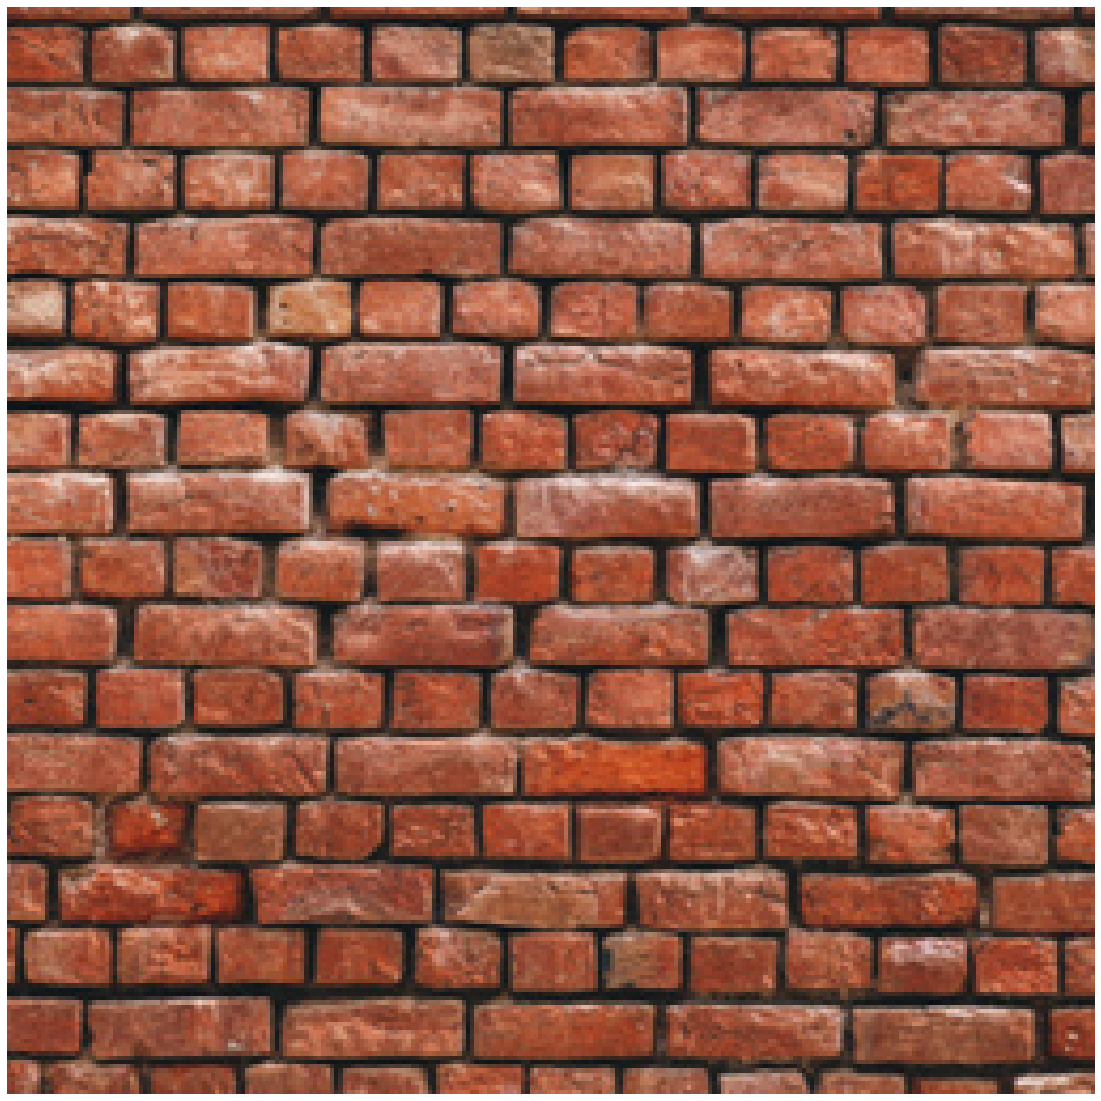

In [82]:
plt.figure(figsize=(20, 20))

plt.imshow(r, cmap="gray")
plt.axis('off')

#### What we've achived so far

On the left we have an initial edges detector using the Sobel operator.

On the right we have our normal map.

This isn't our goal, it's useless so far.

We think our problem is noise.

(-0.5, 255.5, 255.5, -0.5)

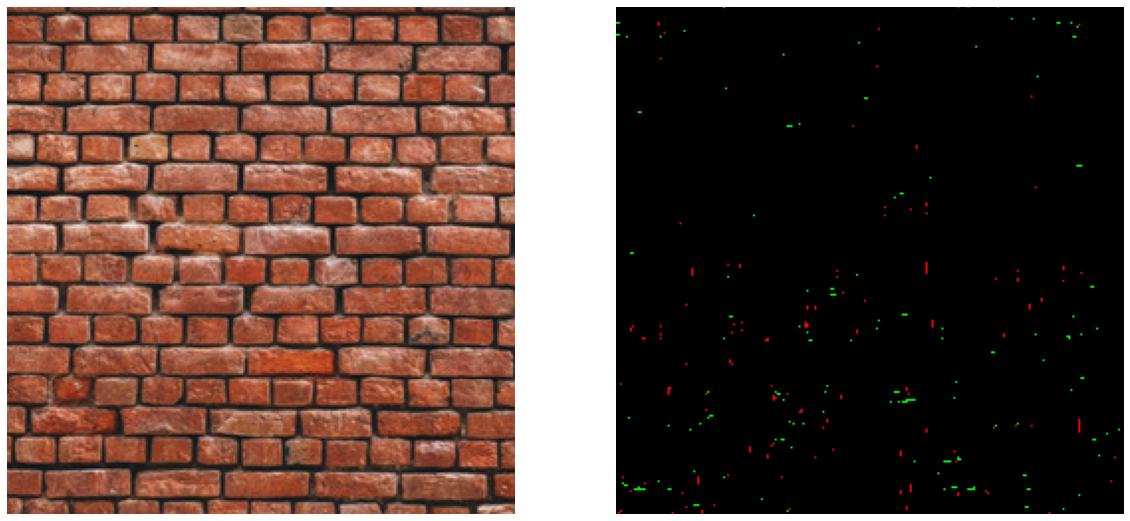

In [90]:
plt.figure(figsize=(20, 20))

plt.subplot(121)
plt.imshow(r, cmap="gray")
plt.axis('off')

plt.subplot(122)
plt.imshow(der.astype(np.uint8))
plt.axis('off')

#### These are the RGB channels

(-0.5, 639.5, 479.5, -0.5)

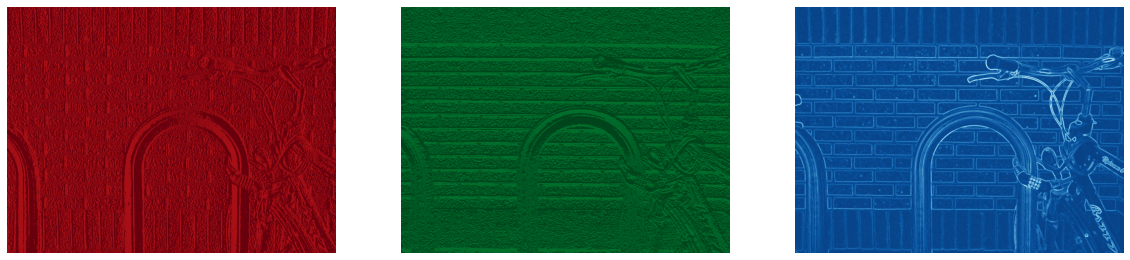

In [36]:
plt.figure(figsize=(20, 20))

plt.subplot(131)
plt.imshow(inv(normal[:,:,0]), cmap="Reds", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(132)
plt.imshow(inv(normal[:,:,1]), cmap="Greens", vmin=0, vmax=255)
plt.axis('off')

plt.subplot(133)
plt.imshow(normal[:,:,2], cmap="Blues", vmin=0, vmax=255)
plt.axis('off')

(-0.5, 639.5, 479.5, -0.5)

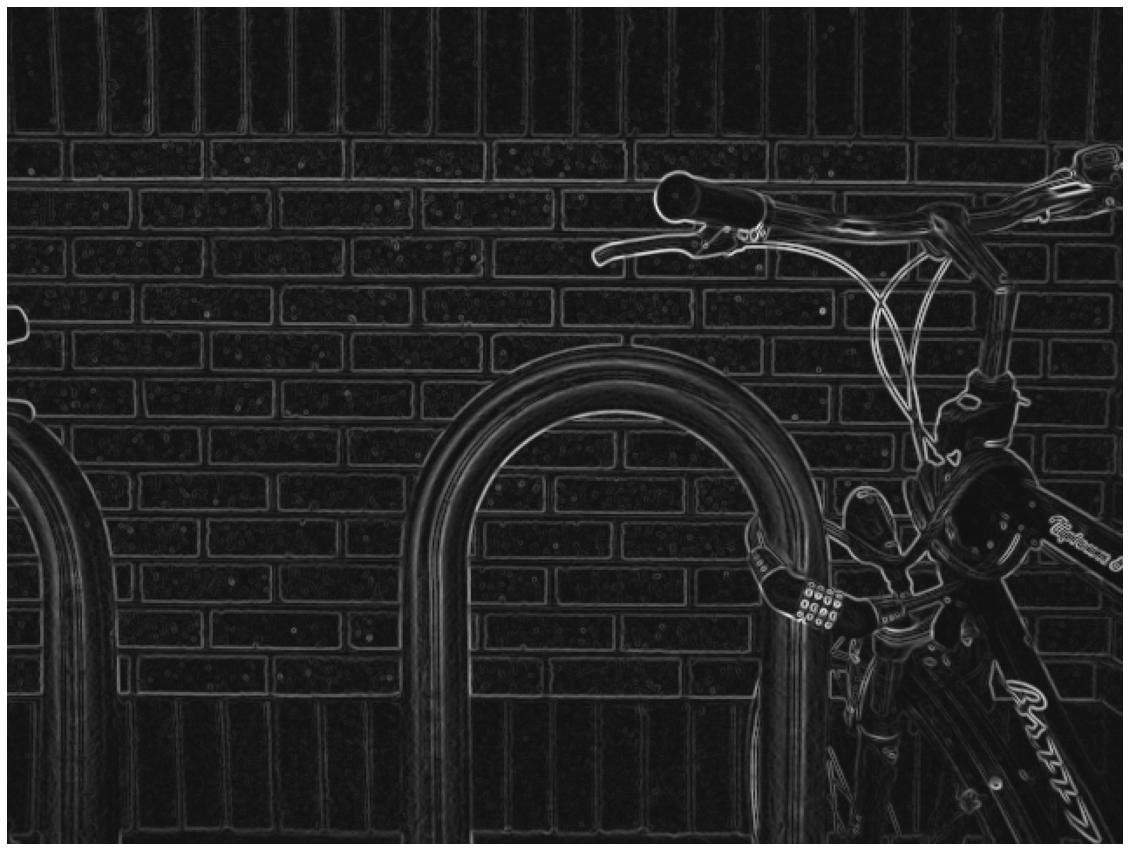

In [37]:
plt.figure(figsize=(20, 20))
plt.imshow(inv(normal[:,:,2]), cmap="gray", vmin=0, vmax=255)
plt.axis('off')

#### Bibliography

##### Normal Map

https://en.wikipedia.org/wiki/Lambertian_reflectance

https://cpetry.github.io/NormalMap-Online/

https://www.quora.com/How-are-normal-maps-made

https://stackoverflow.com/questions/13983189/opengl-how-to-calculate-normals-in-a-terrain-height-grid/13983431#13983431

https://en.wikipedia.org/wiki/Von_Neumann_neighborhood

https://azgaar.wordpress.com/2018/02/26/image-converter/

https://en.wikipedia.org/wiki/Sobel_operator

http://homepages.inf.ed.ac.uk/rbf/HIPR2/sobel.htm

K. Engel (2006). Real-time volume graphics.

##### Bump Map

https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm